# Predict plaque

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

# math/matrix/algebra packages
import numpy as np
import math
import os


# image analysis packages
from PIL import Image

# keras
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Define the model:

In [2]:
# define dice coefficient:------------------------------------------------------

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


# redefine network with image size:

# define network:---------------------------------------------------------------
def set_up_model(modelpath):
    inputs = Input((None, None, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv10 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(lr = 0.0001), loss=dice_coef_loss, metrics=[dice_coef])
    # load weights:
    model.load_weights(modelpath)

    return model

### Load data:

In [3]:
test_im=np.load("../data/plaque_data.npz")['arr_4']
test_labels=np.load("../data/plaque_data.npz")['arr_5']

test_im=test_im.reshape((test_im.shape[0],test_im.shape[1],test_im.shape[2],1))
test_labels=test_labels.reshape((test_labels.shape[0],test_labels.shape[1],test_labels.shape[2],1))


### Load model weights:

In [5]:
p_model=set_up_model('../models/plaque_model_weights.hdf5')

In [6]:
l,d=p_model.evaluate(test_im,test_labels, batch_size=32)
print("Plaque model dice coefficient: " + str(d))

39/39 [==============================] - 8s 215ms/step
Plaque model dice coefficient: 0.8378483683635027


### Visualize predictions:

In [7]:
# predict images:
pred_p=p_model.predict(test_im, batch_size=32)

(-0.5, 479.5, 607.5, -0.5)

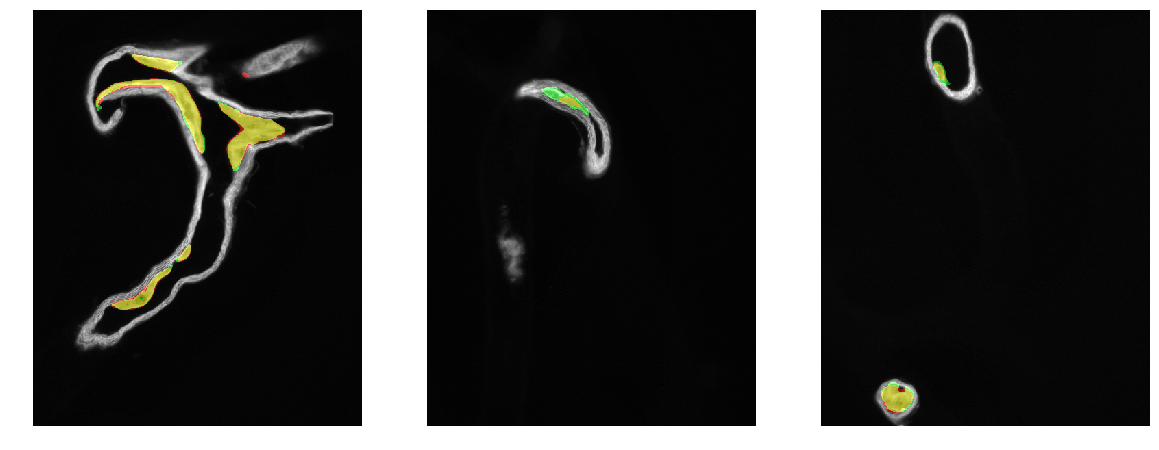

In [8]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.subplot(1, 3, 1)
tmp=np.zeros((test_im.shape[1],test_im.shape[2],3))
tmp[:,:,0] = tmp[:,:,0] + np.reshape(test_im[20],(test_im.shape[1],test_im.shape[2])) + 0.5*pred_p[20,:,:,0]
tmp[:,:,1] = tmp[:,:,1] + np.reshape(test_im[20],(test_im.shape[1],test_im.shape[2])) + 0.5*np.reshape(test_labels[20],(test_labels.shape[1],test_labels.shape[2]))
tmp[:,:,2] = tmp[:,:,2] + np.reshape(test_im[20],(test_im.shape[1],test_im.shape[2])) 
tmp[tmp>1]=1
plt.imshow(tmp)
plt.axis('off')

plt.subplot(1, 3, 2)
tmp=np.zeros((test_im.shape[1],test_im.shape[2],3))
tmp[:,:,0] = tmp[:,:,0] + np.reshape(test_im[1],(test_im.shape[1],test_im.shape[2])) + 0.5*pred_p[1,:,:,0]
tmp[:,:,1] = tmp[:,:,1] + np.reshape(test_im[1],(test_im.shape[1],test_im.shape[2])) + 0.5*np.reshape(test_labels[1],(test_labels.shape[1],test_labels.shape[2]))
tmp[:,:,2] = tmp[:,:,2] + np.reshape(test_im[1],(test_im.shape[1],test_im.shape[2])) 
tmp[tmp>1]=1
plt.imshow(tmp)
plt.axis('off')

plt.subplot(1, 3, 3)
tmp=np.zeros((test_im.shape[1],test_im.shape[2],3))
tmp[:,:,0] = tmp[:,:,0] + np.reshape(test_im[2],(test_im.shape[1],test_im.shape[2])) + 0.5*pred_p[2,:,:,0]
tmp[:,:,1] = tmp[:,:,1] + np.reshape(test_im[2],(test_im.shape[1],test_im.shape[2])) + 0.5*np.reshape(test_labels[2],(test_labels.shape[1],test_labels.shape[2]))
tmp[:,:,2] = tmp[:,:,2] + np.reshape(test_im[2],(test_im.shape[1],test_im.shape[2])) 
tmp[tmp>1]=1
plt.imshow(tmp)
plt.axis('off')